# Performance Result Plot
From log files, creates plots for
- losses
- training time

In [13]:
import os
import numpy as np
import pandas as pd
import re
import seaborn as sns

## 1. Plot Losses

In [14]:
def infer_process_id(idx_start,idx_max):
    """
    idx_start: a list of indices, each marks the starting point of a new process's log
    """
    res = []
    for i,idx in enumerate(idx_start):
        if i > 0:
            idx_before = idx_start[i-1]
            res.extend([i-1]*(idx - idx_before))
    res.extend([i]*(idx_max - idx))
    
    return res

In [15]:
def get_losses(path):
    with open(path,'r') as f:
        text = f.readlines()

    line_data_size = [line for line in text if line.startswith('The number of training images =')][0]
    data_size = int(line_data_size.split()[-1])
    print('data size:',data_size)
    text = [line for line in text if line.startswith('(epoch:')]
    
    pattern1 = re.compile('^\((.+)\) (.*)$') # split "(...) ..."
    pattern2 = re.compile('(.+?:.+? )') # split "G_GAN_1: xyz G_GAN_2: abc ..."

    l_row = []
    for line in text:
        line_parsed = pattern1.findall(line)[0]
        line_x = line_parsed[0]
        line_y = line_parsed[1]

        dict_x = {pair.split(':')[0].strip():pair.split(':')[1].strip() for pair in line_x.split(',')}

        line_y_parsed = pattern2.findall(line_y)
        dict_y = {pair.split(':')[0].strip():pair.split(':')[1].strip() for pair in line_y_parsed}

        dict_row = {**dict_x,**dict_y}
        l_row.append(dict_row)

    df_plot = pd.DataFrame.from_dict(l_row,orient='columns').astype(float)
    
    # find the starting point of a monotonically increasing epoch sequence
    idx_start = [0] + df_plot['epoch'].loc[df_plot['epoch'].diff() < 0].index.tolist()
    n_proc = len(idx_start)
    
    df_plot['x'] = df_plot['epoch'] + df_plot['iters'] / data_size * n_proc

    # drop unnecessary columns
    df_plot = df_plot[[c for c in df_plot.columns if c.startswith('D_') or c.startswith('G_') or c=='x']]

    # mark process id
    # df_plot = df_plot.loc[idx_start[0]:(idx_start[1]-1)]
    df_plot['process_id'] = infer_process_id(idx_start,idx_max=df_plot.shape[0])

    # reshape the table from wide to long
    df_plot = pd.melt(df_plot, id_vars=['x','process_id'])
    
    return df_plot

In [16]:
def plot_losses(df_plot):
    """
    df_plot: output from get_losses()
    """
    n_proc = df_plot['process_id'].nunique()
    
    g = sns.FacetGrid(df_plot,'process_id',hue='variable')
    g.map(sns.lineplot,'x','value')
    g.fig.set_figwidth(30)
    g.fig.set_figheight(8*n_proc)

In [17]:
fn = 'ws train 20211124 gpu2,batch_size4 slow.log'
dir_log = '/userfs/log'

df_plot = get_losses(f'{dir_log}/{fn}')
df_plot

data size: 709


,x,process_id,variable,value
0,0.141044,0,G_GAN_1,0.897
1,0.282087,0,G_GAN_1,0.880
2,0.423131,0,G_GAN_1,1.111
3,0.564175,0,G_GAN_1,1.312
4,0.705219,0,G_GAN_1,1.205
...,...,...,...,...
28615,200.423131,0,D_fake_5,0.000
28616,200.564175,0,D_fake_5,0.000
28617,200.705219,0,D_fake_5,0.000
28618,200.846262,0,D_fake_5,0.000


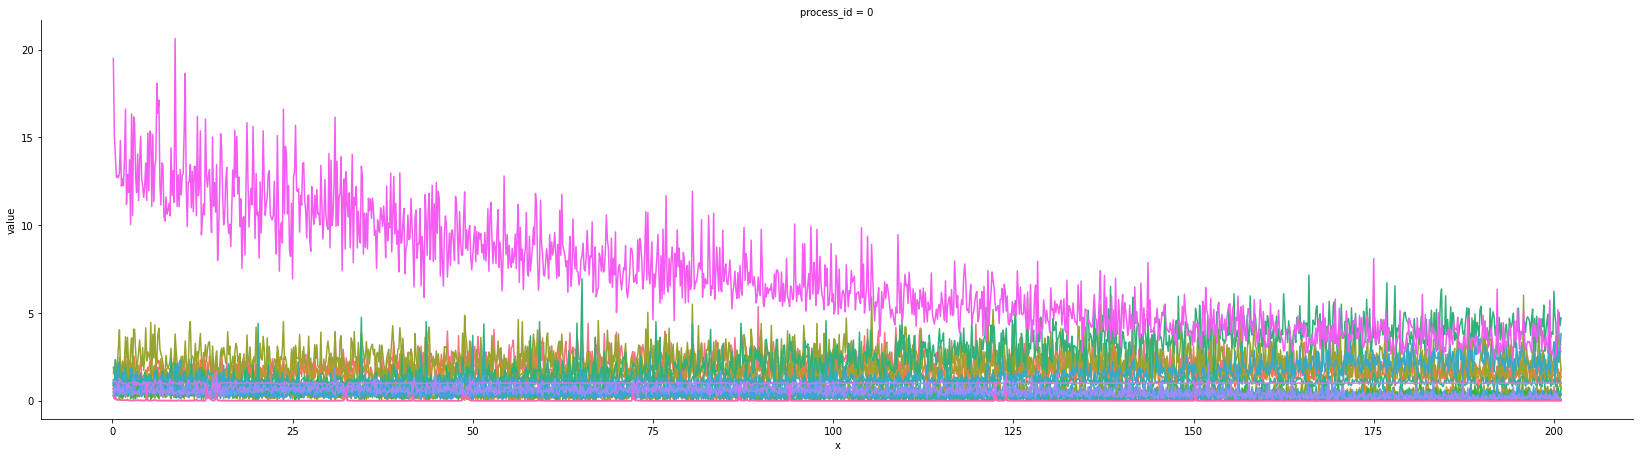

In [18]:
plot_losses(df_plot)